In [1]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal). 

In [108]:
import py4DSTEM
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt

# Verify libraries
print("All libraries imported successfully!")

print(f"py4DSTEM version: {py4DSTEM.__version__}")
print(f"HyperSpy version: {hs.__version__}")

All libraries imported successfully!
py4DSTEM version: 0.14.16
HyperSpy version: 2.3.0


In [109]:
# Load dataset as HyperSpy signal
signal = hs.load("Si-SiGe.dm4")

# Inspect navigation and signal axes of dataset
print(signal.axes_manager)

<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 


In [110]:
# --------------------------------------------------------------------------------------------------------------------- #
# Reciprocal and real space axes appear permutated, such that the "navigation axes" correspond to the reciprocal space  #
# and the signal axes the real space. Axes are defined as such in signal.axes_manager.                                  #
# --------------------------------------------------------------------------------------------------------------------- #

# (Re-)Define navigation and signal axes
signal.axes_manager.navigation_axes[0].name = "Qx" # Reciprocal (diffraction) space, horizontal axis
signal.axes_manager.navigation_axes[1].name = "Qy" # Reciprocal (diffraction) space, vertical axis

signal.axes_manager.signal_axes[0].name = "Rx" # Real (scan) space, horizontal axis
signal.axes_manager.signal_axes[1].name = "Ry" # Real (scan) space, vertical axis

# Verify updated navigation and signal axes
print(signal.axes_manager)

<Axes manager, axes: (448, 480|17, 77)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
              Qx |    448 |      0 |       0 |   0.062 |   1/nm 
              Qy |    480 |      0 |       0 |   0.062 |   1/nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
              Rx |     17 |      0 |       0 |       2 |     nm 
              Ry |     77 |      0 |       0 |       2 |     nm 


In [111]:
# Verify dimensionality of the 4D-STEM dataset
print("Navigation dimensions:", signal.axes_manager.navigation_dimension)
print("Signal dimensions:", signal.axes_manager.signal_dimension)

Navigation dimensions: 2
Signal dimensions: 2


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [112]:
# Load as 4D-STEM dataset
filepath = "Si-SiGe.dm4"
dataset = py4DSTEM.io.import_file(filepath)

print("Dataset successfully loaded!")

# Load calibration dataset
filepath_calib = "Diffraction Si_Au_Calib.dm4"
dataset_calib = py4DSTEM.io.import_file(filepath_calib)

print("Calibration dataset successfully loaded!")

Dataset successfully loaded!
Calibration dataset successfully loaded!


In [113]:
# Inspect experimental dataset
print(type(dataset))
print("Dataset shape:", dataset.data.shape)
print(dataset.calibration)

<class 'py4DSTEM.datacube.datacube.DataCube'>
Dataset shape: (480, 448, 77, 17)
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    1
             R_pixel_size:    1
             Q_pixel_units:   pixels
             R_pixel_units:   pixels
             QR_flip:         False
)


In [114]:
# Fix axes after import
dataset.data = np.transpose(dataset.data, (2, 3, 0, 1))

# Verify corrected axes
print("Dataset shape:", dataset.data.shape)

Dataset shape: (77, 17, 480, 448)


In [115]:
# Set scan step size of experimental dataset
scan_step_size = 2.0 # nm 
reciprocal_step_size = 0.0062 # A^-1

dataset.calibration.set_R_pixel_size(scan_step_size)
dataset.calibration.set_R_pixel_units("nm")
dataset.calibration.set_Q_pixel_size(reciprocal_step_size)
dataset.calibration.set_Q_pixel_units("A^-1")

# Verify new scan step size of experimental dataset
print("Scan step size set!")
print(dataset.calibration)

Scan step size set!
Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    0.0062
             R_pixel_size:    2.0
             Q_pixel_units:   A^-1
             R_pixel_units:   nm
             QR_flip:         False
)


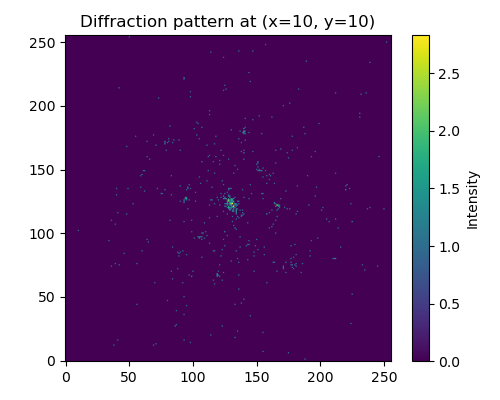

Calibration CoM: (130.16, 124.53)


In [118]:
# CoM analysis and correction on Si-Au

# Choose representative scan position from calibration dataset
Rx0_calib = dataset_calib.data.shape[0] // 2
Ry0_calib = dataset_calib.data.shape[1] // 2

dp_calib = dataset_calib.data[Rx0_calib, Ry0_calib].astype(float)
plt.figure(figsize=(5, 4))
plt.imshow(np.sqrt(dp_calib), origin="lower") # sqrt to enhance contrast
plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0_calib}, y={Ry0_calib})")
plt.tight_layout()
plt.show()

# Average diffraction pattern over scan positions
dp_calib_avg = dataset_calib.data.mean(axis=(0, 1)).astype(float)

qy = np.arange(dp_calib_avg.shape[0])
qx = np.arange(dp_calib_avg.shape[1])
QX, QY = np.meshgrid(qx, qy)

I = dp_calib_avg.sum()
qx_calib = (QX * dp_calib_avg).sum() / I
qy_calib = (QY * dp_calib_avg).sum() / I

print(f"Calibration CoM: ({qx_calib:.2f}, {qy_calib:.2f})")

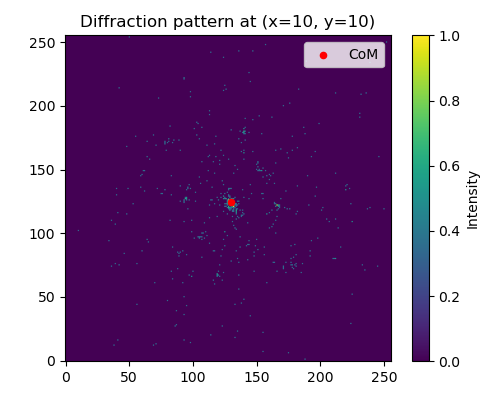

In [119]:
# Visualize CoM on diffraction pattern
plt.figure(figsize=(5, 4))
plt.imshow(np.sqrt(dp_calib), origin="lower") # sqrt to enhance contrast

com_x_calib = 130.16 # Geometric center at 128
com_y_calib = 124.53 # Geometric center at 128
plt.scatter(com_x_calib, com_y_calib, color='red',zorder=10, s=20, label='CoM')

plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0_calib}, y={Ry0_calib})")
plt.legend()
plt.tight_layout()
plt.show()

Using scan position: (38, 8)


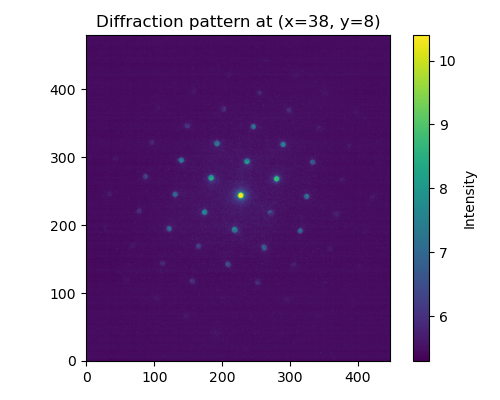

Experimental CoM: (224.26, 240.10)


In [120]:
# Perform CoM correction on experimental dataset

# Choose representative scan position for experimental data
Rx0 = dataset.data.shape[0] // 2
Ry0 = dataset.data.shape[1] // 2

print("Using scan position:", (Rx0, Ry0))
dp = dataset.data[Rx0, Ry0].astype(float)

plt.figure(figsize=(5, 4))
plt.imshow(np.log(dp), origin="lower")
plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0}, y={Ry0})")
plt.tight_layout()
plt.show()

# Compute CoM from selected scan position
Qy, Qx = dp.shape 

qy = np.arange(Qy)[:, None]   # vertical
qx = np.arange(Qx)[None, :]   # horizontal

I = dp.sum()

qx_exp = (qx * dp).sum() / I
qy_exp = (qy * dp).sum() / I

print(f"Experimental CoM: ({qx_exp:.2f}, {qy_exp:.2f})")

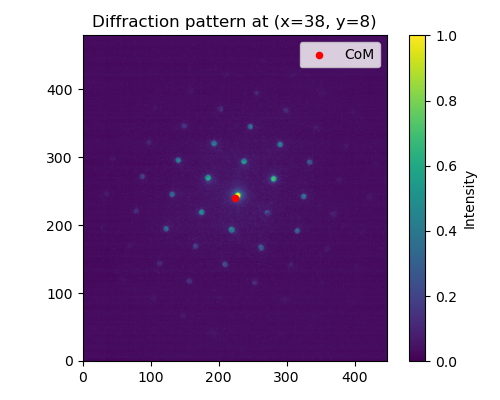

In [121]:
# Visualize CoM on diffraction pattern
plt.figure(figsize=(5, 4))
plt.imshow(np.log(dp), origin="lower")

plt.scatter(qx_exp, qy_exp, color='red',zorder=10, s=20, label='CoM')

plt.colorbar(label="Intensity")
plt.title(f"Diffraction pattern at (x={Rx0}, y={Ry0})")
plt.legend()
plt.tight_layout()
plt.show()

In [122]:
# Define CoM correction
Qy, Qx = dp.shape

print("Dataset shape:", dataset.data.shape)

qx_target = (Qx - 1) / 2 # Geometric center
qy_target = (Qy - 1) / 2 # Geometric center

print("Geometric center:", qx_target, qy_target)

dx = qx_target - qx_exp # Shift along the Qx axis
dy = qy_target - qy_exp # Shift along the Qy axis

print(f"Applying CoM shifts: dx = {dx:.2f}, dy = {dy:.2f}")

Dataset shape: (77, 17, 480, 448)
Geometric center: 223.5 239.5
Applying CoM shifts: dx = -0.76, dy = -0.60


In [127]:
from scipy.ndimage import shift

Ry, Rx, Qy, Qx = dataset.data.shape

corrected_data = np.zeros_like(dataset.data, dtype=float)

for iy in range(Ry):
    for ix in range(Rx):
        dp = dataset.data[iy, ix].astype(float)  # shape (Qy, Qx)
        
        # Apply shift
        dp_shifted = shift(
            dp,
            shift=(dy, dx),     # (rows, cols)
            order=1,            # bilinear interpolation
            mode="nearest"      # edge handling
        )
        
        corrected_data[iy, ix] = dp_shifted

print("CoM correction successfully applied!")

CoM correction successfully applied!


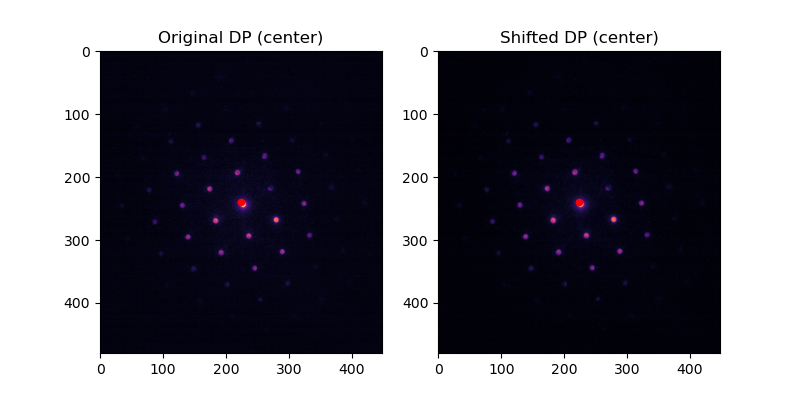

In [128]:
# Visualize diffraction pattern before & after CoM correction
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(np.log(dataset.data[Ry//2, Rx//2]), cmap="magma")
plt.scatter(223.5, 239.5, color='red',zorder=10, s=20, label='CoM')
plt.title("Original DP (center)")

plt.subplot(1,2,2)
plt.imshow(np.log(corrected_data[Ry//2, Rx//2]), cmap="magma")
plt.scatter(223.5, 239.5, color='red',zorder=10, s=20, label='CoM')
plt.title("Shifted DP (center)")
plt.show()

In [129]:
# Numerical verification of corrected data
dp_corr = corrected_data[iy, ix]

qy = np.arange(Qy)[:, None]
qx = np.arange(Qx)[None, :]

I = dp_corr.sum()
qx_corr = (qx * dp_corr).sum() / I
qy_corr = (qy * dp_corr).sum() / I

print("Corrected CoM:", qx_corr, qy_corr)
print("Target center:", (Qx - 1)/2, (Qy - 1)/2)

Corrected CoM: 222.82201116319578 239.528246329704
Target center: 223.5 239.5


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

#### Notes: 
- Bright Field (BF): sensitive to diffraction contrast, strain, crystal orientation; contrast arises from redistribution of intensity; not monotonic with atomic number
- Annular Dark Field (ADF): sensitive to high-angle scattering; produces a Z-contrast that scales with intensity

In [130]:
# Define reciprocal-space coordinates
Ry, Rx, Qy, Qx = corrected_data.shape

qy = np.arange(Qy)[:, None]
qx = np.arange(Qx)[None, :]

qy0 = (Qy - 1) / 2
qx0 = (Qx - 1) / 2

qr = np.sqrt((qy - qy0)**2 + (qx - qx0)**2) # Radius map in reciprocal space

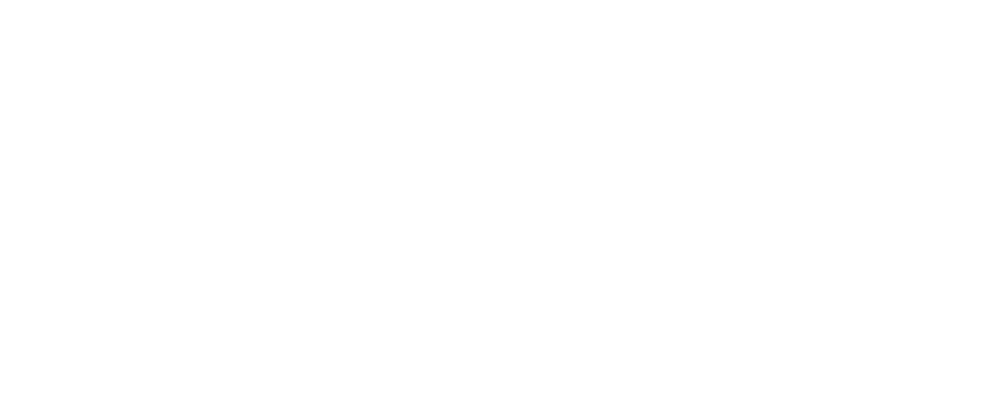

In [131]:
# Define BF and ADF mask (radii arbitrarily chosen)
r_bf = 6.0
bf_mask = qr <= r_bf

r_adf_inner = 40.0
r_adf_outer = 60.0

adf_mask = (qr >= r_adf_inner) & (qr <= r_adf_outer)

# Visualize masks
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(bf_mask, origin="lower")
plt.title("BF mask")

plt.subplot(1,2,2)
plt.imshow(adf_mask, origin="lower")
plt.title("ADF mask")

plt.tight_layout()
plt.show()

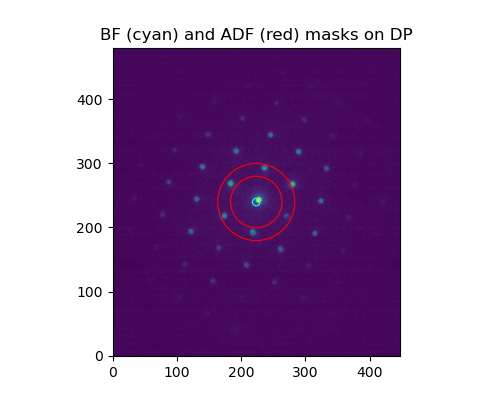

In [132]:
iy, ix = 38, 8  # same position you used before
dp = corrected_data[iy, ix]

plt.figure(figsize=(5,4))
plt.imshow(np.log(dp), origin="lower")
plt.contour(bf_mask, colors="cyan", linewidths=0.8)
plt.contour(adf_mask, colors="red", linewidths=0.8)
plt.title("BF (cyan) and ADF (red) masks on DP")

plt.show()

In [133]:
# Compute BF and ADF images
BF = np.zeros((Ry, Rx))
ADF = np.zeros((Ry, Rx))

for iy in range(Ry):
    for ix in range(Rx):
        dp = corrected_data[iy, ix]

        BF[iy, ix] = np.sum(dp[bf_mask])
        ADF[iy, ix] = np.sum(dp[adf_mask])

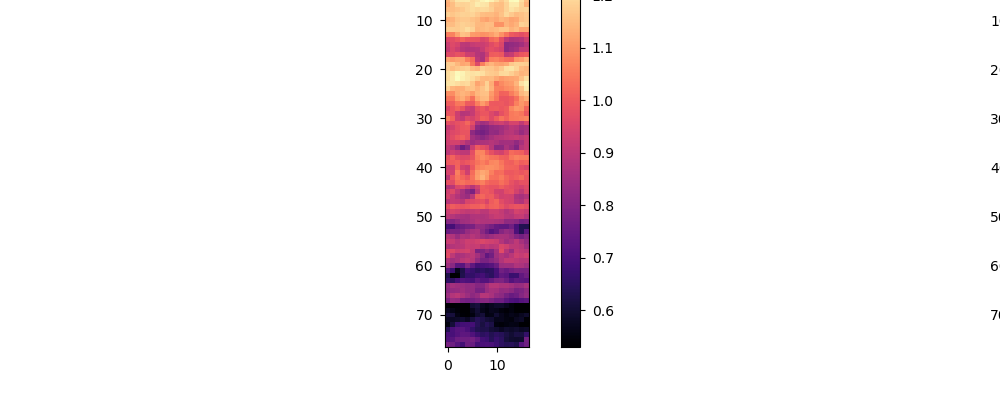

In [134]:
# Plot the results with percentile-based contrast scaling
plt.figure(figsize=(10,4))

bf_vmin, bf_vmax = np.percentile(BF, [1, 99])
adf_vmin, adf_vmax = np.percentile(ADF, [1, 99])

plt.subplot(1,2,1)
plt.imshow(BF, cmap="magma", vmin=bf_vmin, vmax=bf_vmax)
plt.title("Virtual Bright Field (BF)", pad=20)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(ADF, cmap="magma", vmin=adf_vmin, vmax=adf_vmax)
plt.title("Virtual Annular Dark Field (ADF)", pad=20)
plt.colorbar()

plt.tight_layout()
plt.show()

## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

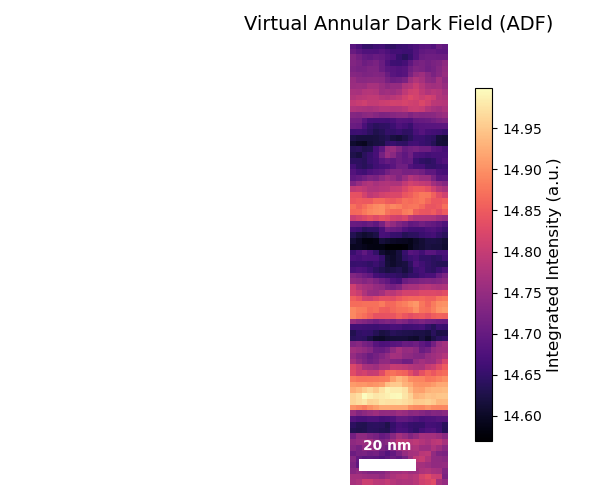

In [135]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

# ---- USER-DEFINED PARAMETERS ----
pixel_size_nm = dataset.calibration.R_pixel_size
scale_bar_length = 20 # nm
scale_bar_pixels = int(scale_bar_length / pixel_size_nm)

# ---- FIGURE ----
fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(np.log(ADF), cmap="magma", origin="upper")
ax.set_title("Virtual Annular Dark Field (ADF)", fontsize=14, pad=10)
ax.set_axis_off()

if scale_bar_pixels < ADF.shape[1] - 5:
    bar_x = 1
    bar_y = ADF.shape[0] - 5

    scale_bar = Rectangle(
        (bar_x, bar_y),
        scale_bar_pixels,
        2,
        fill=True,
        color="white",
        linewidth=0
    )
    ax.add_patch(scale_bar)

    ax.text(
        bar_x + scale_bar_pixels / 2,
        bar_y - 1,
        f"{scale_bar_length} nm",
        ha="center",
        va="bottom",
        color="white",
        fontsize=10,
        fontweight="bold"
    )

cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label("Integrated Intensity (a.u.)", fontsize=12)

plt.tight_layout()
plt.savefig("virtual_adf_figure_sisige.png", dpi=300, bbox_inches="tight")
plt.show()

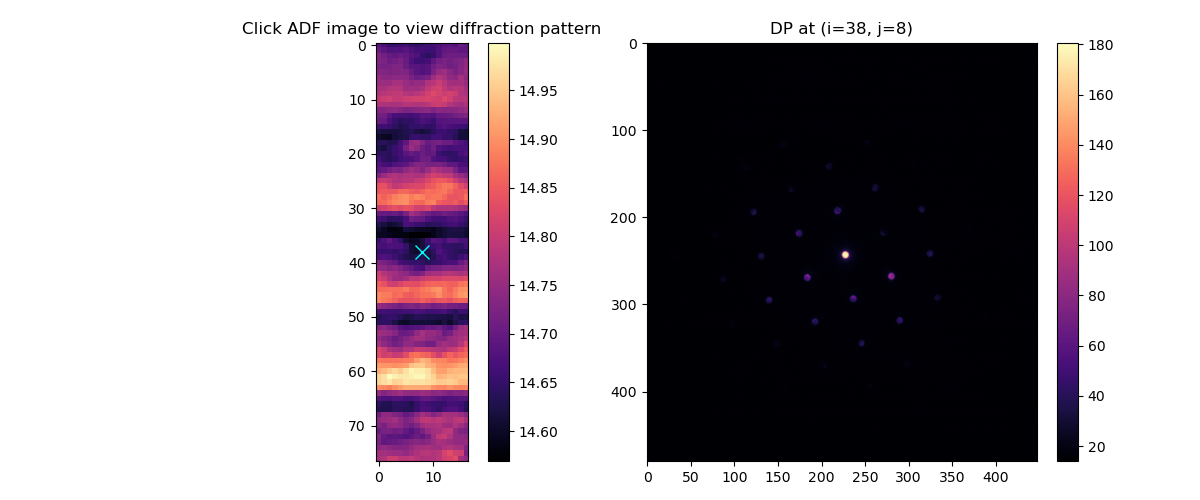

In [136]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

data4d = dataset.data   # adjust if your variable name differs
sx, sy, ny, nx = data4d.shape

fig, (ax_img, ax_dp) = plt.subplots(1, 2, figsize=(12,5))

im0 = ax_img.imshow(np.log(ADF + 1), cmap="magma")
ax_img.set_title("Click ADF image to view diffraction pattern")
plt.colorbar(im0, ax=ax_img, fraction=0.046, pad=0.04)

# Initialize DP display
dp0 = np.sqrt(data4d[sx//2, sy//2])
im1 = ax_dp.imshow(dp0, cmap="magma")
ax_dp.set_title(f"DP at (i={sx//2}, j={sy//2})")
plt.colorbar(im1, ax=ax_dp, fraction=0.046, pad=0.04)

marker = ax_img.plot([sy//2], [sx//2], marker="x", markersize=10,
                     color="cyan", linestyle="")[0]

def onclick(event):
    if event.inaxes != ax_img or event.xdata is None or event.ydata is None:
        return

    j = int(round(event.xdata))
    i = int(round(event.ydata))

    if not (0 <= i < sx and 0 <= j < sy):
        return

    marker.set_data([j], [i])

    dp = np.sqrt(data4d[i, j])
    im1.set_data(dp)
    im1.set_clim(vmin=np.min(dp), vmax=np.max(dp))
    ax_dp.set_title(f"DP at (i={i}, j={j})")

    fig.canvas.draw_idle()

cid = fig.canvas.mpl_connect("button_press_event", onclick)

plt.tight_layout()
plt.show()

## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

#### See GitHub Repository for finalized assignment, imported figures, and updated README.md.